In [1]:
#from google.colab import drive
#drive.mount('gdrive')

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Flatten, Conv1D, AveragePooling1D, Dropout
from tensorflow.keras.layers import concatenate, Conv2D, MaxPooling2D, MaxPooling1D, BatchNormalization, Softmax
from tensorflow.keras.models import Model, Sequential
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

# Bijectors and Normalizing Flows
- Build generative models, which aim to learn the underlying data distribution itself
- Useful because it is able to "generate" samples that plausibly could have come from the dataset
- Tells you if a given instance is likely (useful for anomaly detection)

## Change of variables formula
- Computes the probability density function of a random variable under a smooth invertible transformation
- Consider change of variables $X = f(Z)$ where where $Z,X \in \mathbb{R}^d$ and $f: \mathbb{R}^d \rightarrow \mathbb{R}^d$ with probability density functions for $Z$ and $X$ denoted by $p_z$ and $p_x$
- Change of variables formula:
$p_x(x) = p_z(z) \cdot |det \, J_f(z)|^{-1}$ where J is the Jacobian

## Normalizing Flows
- class of models that exploit change of variables formula to estimate an unknwon target data density
- models the distribution of data $p_x$ using a random variable $Z$ with a simple distribution $p_z$ (e.g. isotropic Gaussian) such that $X$ can be written as $X=f_{\theta}(Z)$ where $\theta$ is a parameter vector that parameterizes the smooth invertible function $f_\theta$
- $f_\theta$ is modeled using a neural network with parameters $\theta$ which are learned from the data
- neural netork must be designed to be invertible (not usually the case)
- in practice, we often construct neural networks by composing multiple simpler blocks together. In TensorFlow Probability, these simpler blocks are called *bijectors*
- apply principle of maximum likelihood to learn $\theta_{ML}$:
$$
\begin{align}
\theta_{ML} &= arg \, max \, log \, P(D;\theta) \\
where \, log \, P(D;\theta) &= \sum_{x \in D} log \, p_z(f_{\theta}^{-1}(x)) \, - \, log \, |det \, J_{f_{\theta}^{-1}}(x)| \text{ (change of variables formula)}
\end{align}
$$


## Bijectors

In [3]:
tfb = tfp.bijectors # used to transform tensors - they have methods to perform forward and inverse transformations

z = tf.constant([1., 2., 3.])

scale = tfb.Scale(2.) 
x = scale.forward(z)
x

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([2., 4., 6.], dtype=float32)>

In [4]:
scale.inverse(tf.constant([5., 3., 1.]))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([2.5, 1.5, 0.5], dtype=float32)>

In [5]:
scale = tfb.Scale(2.)
shift = tfb.Shift(1.)
scale_and_shift = tfb.Chain([shift, scale]) # applies sequence of bijector objects in REVERSE order

scale_and_shift.forward(z) # scale, then shift

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3., 5., 7.], dtype=float32)>

In [6]:
scale_and_shift.inverse(tf.constant([21., 14., 7.])) # inverse shift, then inverse scale

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([10. ,  6.5,  3. ], dtype=float32)>

In [7]:
normal = tfd.Normal(loc=0., scale=1.)
z = normal.sample(3)
x = scale_and_shift.forward(z)
x

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.1484928,  4.0239944, -0.3260641], dtype=float32)>

In [8]:
log_prob_z = normal.log_prob(z)

# change of variables formula:
log_prob_x = normal.log_prob(z) - scale_and_shift.forward_log_det_jacobian(z, event_ndims=0)
# normal.log_prob knows how to reduce dimensions of event space but need to explicity tell forward_log_det_jacobian the # of event dims 
log_prob_x

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-2.1890883, -2.7551532, -1.8318914], dtype=float32)>

In [9]:
n = 10000
z = normal.sample(n)

scale = 4.5
shift = 7
scale_and_shift = tfb.Chain([tfb.Shift(shift), tfb.Scale(scale)])

# instead of Chain, can also call a bijector wihtin another bijector
scale_transf = tfb.Scale(scale)
shift_transf = tfb.Shift(shift)
scale_and_shift = shift_transf(scale_transf) # equivalent to Chain 

In [10]:
x = scale_and_shift.forward(z)
np.allclose(x , scale*z + shift)  # confirm that it worked

True

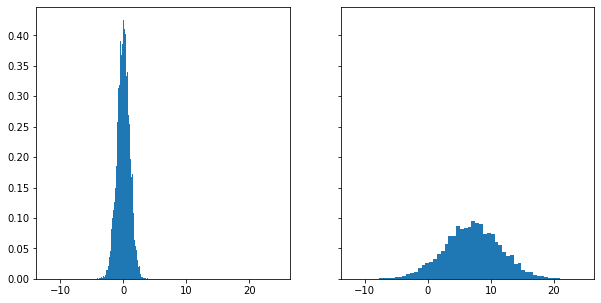

In [11]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,5), sharey=True, sharex=True)
ax1.hist(z, bins=60, density=True)
ax2.hist(x, bins=60, density=True)
plt.show()

In [12]:
inv_x = scale_and_shift.inverse(x)
np.allclose(inv_x, z)

True

In [13]:
log_prob_x = normal.log_prob(z) - scale_and_shift.forward_log_det_jacobian(z, event_ndims=0) # in terms of z

log_prob_x = (normal.log_prob(scale_and_shift.inverse(x))
              + scale_and_shift.inverse_log_det_jacobian(x, event_ndims=0)) # in terms of x

In [14]:
# Broadcasting
x = tf.random.normal(shape=(100,1))

softfloor = tfb.Softfloor(temperature=0.01) # differentiable approximation to tf.math.floor
y = softfloor.forward(x)
print(y.shape)

(100, 1)


In [15]:
softfloor = tfb.Softfloor(temperature=[0.01, 0.1, 1.]) # apply transformation with different parameter values
y = softfloor.forward(x)
print(y.shape)

(100, 3)


In [16]:
def make_plot(nparams, bijector, params, x):
  bijector_params = tuple(getattr(bijector, name) for name in params)
  upper_params = [name[0].upper() + name[1:] for name in params]
  fig = plt.figure(figsize=(14,5))
  lines = plt.plot(np.tile(x, nparams), bijector.forward(x))
  for l in zip(lines, *bijector_params):
    labels = ': {:.2f}, '.join(upper_params) + ': {:.2f}'
    l[0].set_label(labels.format(*l[1:]))
  plt.legend()
  plt.show()

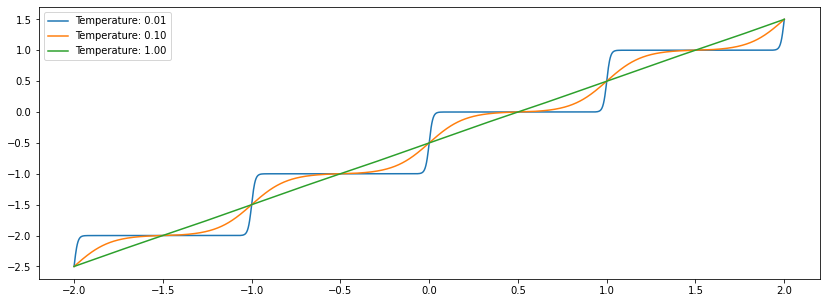

In [17]:
x = np.linspace(-2, 2, 2000)[..., np.newaxis]
make_plot(3, softfloor, ['temperature'], x)

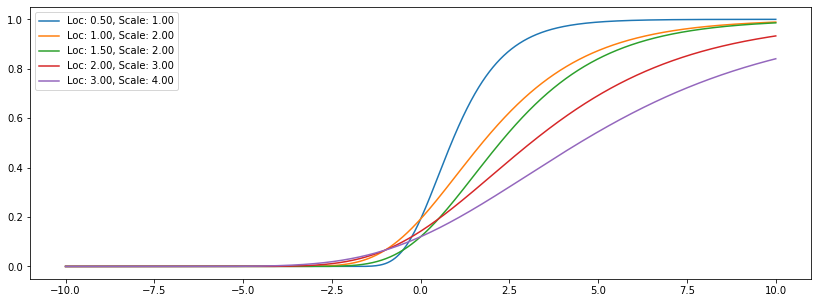

In [18]:
exps = tfb.GumbelCDF(loc=[0.5, 1, 1.5, 2, 3], scale=[1, 2, 2, 3, 4])
x = np.linspace(-10, 10, 2000, dtype=np.float32)[..., np.newaxis]
make_plot(5, exps, ['loc', 'scale'], x)

In [19]:
# higher dimensional bijectors
# represent scale bijectors as a square matrix, B, where y = Bx as opposed to just a scalar as shown previously
bijector = tfb.ScaleMatvecDiag(scale_diag=[1.5, -0.5]) # B is a diagonal matrix (non-diagonal entries are zero)

uniform = tfd.Uniform(low=[0., 0.], high=[1., 1.]) # sample from the unit square (two dimensional)
x = uniform.sample()

y = bijector(x) # maps from rectangle to rectangle
y

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.6959637 , -0.27992177], dtype=float32)>

In [20]:
bijector = tfb.ScaleMatvecTriL(scale_tril=[[-1., 0.],
                                           [-1., -1.]]) # B is a lower triangular matrix (upper right entries are zero)
y = bijector(x) # maps from rectangle to quadrilateral
y

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.4639758, -1.0238193], dtype=float32)>

## LinearOperator and ScaleMatvecLinearOperator

In [21]:
# these allow more flexibility than ScaleMatvecDiag and caleMatvecTriL
scale = tf.linalg.LinearOperatorDiag(diag=[1.5, -0.5]) # subclass of LinearOperator class
bijector = tfb.ScaleMatvecLinearOperator(scale) # convert to bijector using ScaleMatvecLinearOperator (same as the one made before)
y = bijector(x)
y

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.6959637 , -0.27992177], dtype=float32)>

In [22]:
# can do same process for full matrix (rather than just diagonal or lower triangular)
B = [[0.5, 1.5],
     [1.5, 0.5]]
scale = tf.linalg.LinearOperatorFullMatrix(matrix=B)
bijector = tfb.ScaleMatvecLinearOperator(scale)
y = bijector(x)
y

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.0717533 , 0.97588545], dtype=float32)>

In [23]:
# batch operations and broadcasting
x = uniform.sample(10) # B.shape[-1] must equal x.shape[-1], in this case 2=2
x

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[0.44886053, 0.37525928],
       [0.10732555, 0.2851348 ],
       [0.31860888, 0.3733406 ],
       [0.661337  , 0.1269263 ],
       [0.31118476, 0.9802486 ],
       [0.13889289, 0.9075177 ],
       [0.9656341 , 0.4473244 ],
       [0.9066206 , 0.6285068 ],
       [0.6656736 , 0.45307875],
       [0.80676186, 0.3017167 ]], dtype=float32)>

In [24]:
scale = tf.linalg.LinearOperatorDiag(diag=[1.5, -0.5])
scale.to_dense()

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 1.5,  0. ],
       [ 0. , -0.5]], dtype=float32)>

In [25]:
bijector = tfb.ScaleMatvecLinearOperator(scale)
y = bijector(x) # output will be batch shape by event shape
y

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[ 0.6732908 , -0.18762964],
       [ 0.16098833, -0.1425674 ],
       [ 0.47791332, -0.1866703 ],
       [ 0.9920055 , -0.06346315],
       [ 0.46677715, -0.4901243 ],
       [ 0.20833933, -0.45375884],
       [ 1.4484512 , -0.2236622 ],
       [ 1.359931  , -0.3142534 ],
       [ 0.9985104 , -0.22653937],
       [ 1.2101429 , -0.15085834]], dtype=float32)>

In [26]:
# batched bijector to apply multiple bijectors to x
diag = tf.stack((tf.constant([1.,-1.]),
                tf.constant([-1., 1.]))) # (2,2)
scale = tf.linalg.LinearOperatorDiag(diag=diag) # (2,2,2) two bijectors where B = 2x2 matrix
bijector = tfb.ScaleMatvecLinearOperator(scale=scale)

# broadcast samples across both bijectors and broadcast bijectors across all samples (requires x to have a batch dim)
x = tf.expand_dims(x, axis=1)
x.shape

TensorShape([10, 1, 2])

In [27]:
y = bijector(x)
y.shape # sample dim, bijector batch dim, event dim

TensorShape([10, 2, 2])

## TransformedDistribution

In [28]:
normal = tfd.Normal(loc=0., scale=1.)
z = normal.sample(3)

scale_and_shift = tfb.Chain([tfb.Shift(1.), tfb.Scale(2.)])

x = scale_and_shift.forward(z)

log_prob_z = normal.log_prob(z)

log_prob_x1 = log_prob_z - scale_and_shift.forward_log_det_jacobian(z, event_ndims=0)
log_prob_x2 = log_prob_z + scale_and_shift.inverse_log_det_jacobian(x, event_ndims=0)
log_prob_x3 = normal.log_prob(scale_and_shift.inverse(x)) + scale_and_shift.inverse_log_det_jacobian(x, event_ndims=0)
# typically calculate it using only x (log_prob_x3) rather than z --> use this form to minimize nll to optimize bijector parameters
np.allclose(log_prob_x1, log_prob_x2)

True

In [29]:
# base distribution --> transformation --> data distribution
# can sample from base distribution (usually something simple like diagonal Gaussian) and apply transformation to use
                                                                   # generative model to 'generate' plausible samples
# forward pass of bijector is used for sampling
# inverse and inverse Jacobian are used for calculating log likelihood during training

normal = tfd.Normal(loc=0., scale=1.) # base distribution
z = normal.sample(3)

exp = tfb.Exp() # transformation
x = exp.forward(z) # data sample

log_normal = tfd.TransformedDistribution(normal, exp) # define data distribution with distribution object 
log_normal

<tfp.distributions.TransformedDistribution 'expNormal' batch_shape=[] event_shape=[] dtype=float32>

In [30]:
# equivalently:
log_normal = exp(normal) # same as using TransformedDistribution
log_normal

<tfp.distributions.TransformedDistribution 'expNormal' batch_shape=[] event_shape=[] dtype=float32>

In [31]:
log_normal.sample() # sample from base disatribution (normal) and perform forward pass using bijector (exp)

<tf.Tensor: shape=(), dtype=float32, numpy=2.0651793>

In [32]:
log_normal.log_prob(x) # apply change of variables formula using inverse and inverse_log_get_jacobian

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-2.385951  , -1.496285  , -0.43637705], dtype=float32)>

In [33]:
n = 10000
loc = 0
scale = 0.5

normal = tfd.Normal(loc=loc, scale=scale)
print('batch shape:', normal.batch_shape)
print('event shape: ', normal.event_shape)

batch shape: ()
event shape:  ()


In [34]:
exp = tfb.Exp()
log_normal_td = exp(normal) # create TransformedDistribution object

In [35]:
print('batch shape:', log_normal_td.batch_shape)
print('event shape: ', log_normal_td.event_shape)

batch shape: ()
event shape:  ()


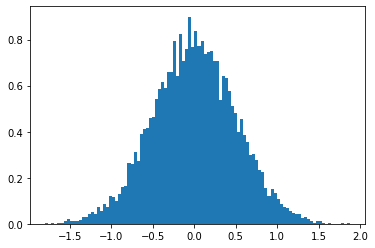

In [36]:
z = normal.sample(n) # sample from base distribution
plt.hist(z, bins=100, density=True)
plt.show()

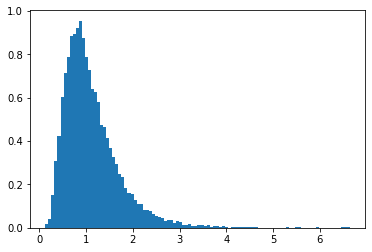

In [37]:
x = log_normal_td.sample(n) # sample from transformed distribution
plt.hist(x, bins=100, density=True)
plt.show()

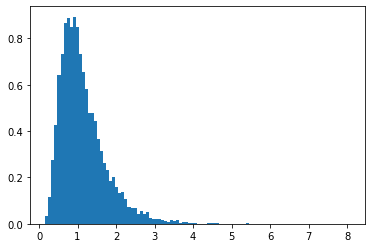

In [38]:
# compare to log normal distribution built into TensorFlow
log_normal = tfd.LogNormal(loc=loc, scale=scale)
l = log_normal.sample(n)
plt.hist(l, bins=100, density=True)
plt.show()

In [39]:
log_prob = log_normal.log_prob(x)
log_prob_td = log_normal_td.log_prob(x)
np.allclose(log_prob, log_prob_td)

True

In [40]:
tril = tf.random.normal((2,4,4)) 
scale_low_tri = tf.linalg.LinearOperatorLowerTriangular(tril) 
# ^ converts tril into lower triangular matrix by converting upper right part of last two dims to zero
# ^ in this case, it creates two 4x4 lower triangular matrices
scale_low_tri.to_dense() # visualize

<tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
array([[[-1.7952086 ,  0.        ,  0.        ,  0.        ],
        [-0.8528584 , -1.4626194 ,  0.        ,  0.        ],
        [ 1.3494258 ,  0.4181135 , -1.417949  ,  0.        ],
        [-0.17694473, -0.16085903, -0.46292174, -2.0953758 ]],

       [[ 0.11327876,  0.        ,  0.        ,  0.        ],
        [-0.9314292 , -0.5139704 ,  0.        ,  0.        ],
        [-0.14283006, -0.8427318 , -1.3306483 ,  0.        ],
        [ 0.99171776, -1.4028883 ,  0.8568086 , -0.00419014]]],
      dtype=float32)>

In [41]:
# define scaling bijector (y = Bx where B is the lower triangular matrices)
scale_lin_op = tfb.ScaleMatvecLinearOperator(scale_low_tri)

In [42]:
# create TransformedDistribution where we can override batch/event shapes of normal (since its shapes are ())
#mvn = tfd.TransformedDistribution(normal, scale_lin_op, batch_shape=[2], event_shape=[4])
# overriding batch/event shape is deprecated

In [43]:
# instead of above, you can equivalently do this:
mvn2 = tfd.MultivariateNormalLinearOperator(loc=0, scale=scale_low_tri)
print(mvn2)

tfp.distributions.MultivariateNormalLinearOperator("MultivariateNormalLinearOperator", batch_shape=[2], event_shape=[4], dtype=float32)


## Subclassing bijectors

In [44]:
class MySigmoid(tfb.Bijector): # note sigmoid bijector already exists so this is just for learning purposes
  def __init__(self, validate_args=False, name='sigmoid'):
    super(MySigmoid, self).__init__(
        validate_args=validate_args, forward_min_event_ndims=0, name=name)
    # validate_args - check any inputs passed to the class method are valid
    # forward_min_event_ndims - need to tell the bijector the min event shape it needs to act upon
  
  def _forward(self, x):
    return tf.math.sigmoid(x)
  
  def _inverse(self, y):
    return tf.math.log(y) - tf.math.log(1-y) # logit is reverse of sigmoid

  def _inverse_log_det_jacobian(self, y):
    return -tf.math.log(y) - tf.math.log(1-y)
    # return -self._forward_log_det_jacobian(self.inverse(y)) # could do it this way if _forward version is correctly calculated
  
  def _forward_log_det_jacobian(self, x):
    # return -tf.math.softplus(-x) - tf.math.softplus(x)
    return -self._inverse_log_det_jacobian(self.forward(x)) # only need to know how to do one of these since can use one to find the other

In [45]:
class Cubic(tfb.Bijector): # (a*x+b)^3
  def __init__(self, a, b, validate_args=False, name='Cubic'):
    super(Cubic, self).__init__(validate_args=validate_args, forward_min_event_ndims=0, name=name)
    self.a = tf.cast(a, tf.float32)
    self.b = tf.cast(b, tf.float32)
    if validate_args:
      assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.a), 1e-5), tf.float32)) == 1.0
      assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.b), 1e-5), tf.float32)) == 1.0

  def _forward(self, x):
    x = tf.cast(x, tf.float32)
    return tf.squeeze(tf.pow(self.a * x + self.b, 3))

  def _inverse(self, y):
    y = tf.cast(y, tf.float32)
    return (tf.math.sign(y) * tf.pow(tf.abs(y), 1/3) - self.b) / self.a

  def _forward_log_det_jacobian(self, x):
    x = tf.cast(x, tf.float32)
    return tf.math.log(3. * tf.abs(self.a)) + 2. * tf.math.log(tf.abs(self.a * x + self.b))

In [46]:
cubic = Cubic(a=[1.0, -2.0], b=[-1.0, 0.4], validate_args=True)

In [47]:
x = tf.constant([[1, 2], [3, 4]])
y = cubic.forward(x)
y

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[   0.      ,  -46.655994],
       [   8.      , -438.97598 ]], dtype=float32)>

In [48]:
cubic.inverse(y)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1, 2],
       [3, 4]], dtype=int32)>

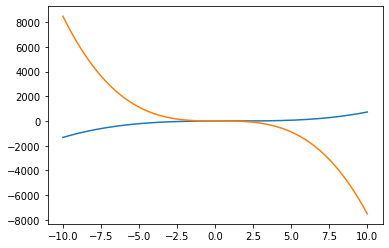

In [49]:
x = np.linspace(-10, 10, 500).reshape(-1,1)
plt.plot(x, cubic.forward(x))

In [50]:
cubic.forward(x).shape # two lines for two values of a/b

TensorShape([500, 2])

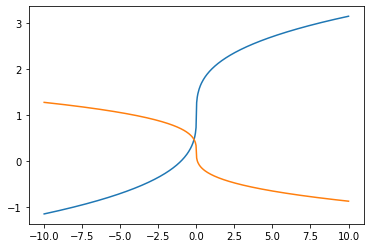

In [51]:
plt.plot(x, cubic.inverse(x))

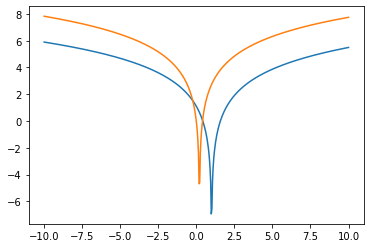

In [52]:
plt.plot(x, cubic.forward_log_det_jacobian(x, event_ndims=0))

In [53]:
# create transformed distribution
normal = tfd.Normal(loc=[0., 0.], scale=[1., 1.])
cubed_normal = tfd.TransformedDistribution(normal, cubic)

In [54]:
n = 1000
g = cubed_normal.sample(n)
g.shape

TensorShape([1000, 2])

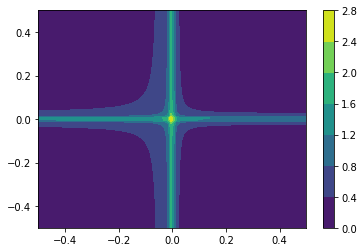

In [55]:
xx = np.linspace(-0.5, 0.5, 100)
yy = np.linspace(-0.5, 0.5, 100)
X, Y = np.meshgrid(xx, yy)

fig, ax = plt.subplots(1,1)
Z = cubed_normal.prob(np.dstack((X, Y)))
Z = tf.reduce_mean(Z, axis=-1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp)

In [56]:
# Invert bijector - inverses another bijector
inverse_cubic = tfb.Invert(cubic)
inv_cubed_normal = inverse_cubic(normal) # create TransformedDistribution

n = 1000
g = inv_cubed_normal.sample(n)
g.shape

TensorShape([1000, 2])

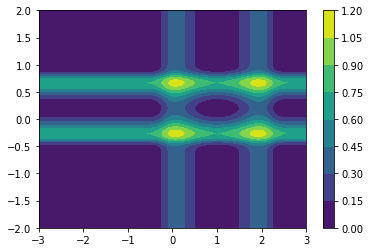

In [57]:
xx = np.linspace(-3, 3, 100)
yy = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(xx, yy)

fig, ax = plt.subplots(1,1)
Z = inv_cubed_normal.prob(np.dstack((X, Y)))
Z = tf.reduce_mean(Z, axis=-1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp)

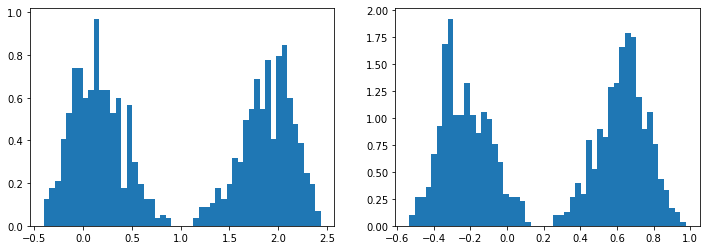

In [58]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(g[...,0], bins=50, density=True)

plt.subplot(1,2,2)
plt.hist(g[...,1], bins=50, density=True)
plt.show()

In [59]:
# training bijectors
# create misture of Gaussians
probs = [0.45, 0.55]
mix_gauss = tfd.Mixture(cat=tfd.Categorical(probs=probs),
                        components=[tfd.Normal(loc=2.3, scale=0.4),
                                    tfd.Normal(loc=-0.8, scale=0.4)])
# create dataset 
X_train = mix_gauss.sample(10000)
X_train = tf.data.Dataset.from_tensor_slices(X_train)
X_train = X_train.batch(128)

X_test = mix_gauss.sample(1000)
X_test = tf.data.Dataset.from_tensor_slices(X_test)
X_test = X_test.batch(128)

print(X_train.element_spec)
print(X_test.element_spec)

TensorSpec(shape=(None,), dtype=tf.float32, name=None)
TensorSpec(shape=(None,), dtype=tf.float32, name=None)


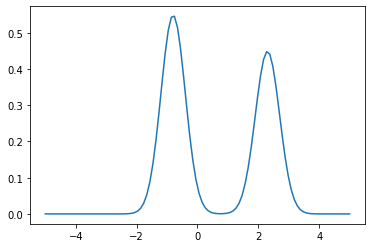

In [60]:
x = np.linspace(-5,5,100)
plt.plot(x, mix_gauss.prob(x))
plt.show()

In [61]:
# make trainable bijector to fit data
trainable_inv_cubcic = tfb.Invert(Cubic(tf.Variable(0.25), tf.Variable(-0.1)))
trainable_inv_cubcic.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.25>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.1>)

In [62]:
# make trainable TransformedDistribution
normal = tfd.Normal(loc=0., scale=1.)
trainable_dist = tfd.TransformedDistribution(normal, trainable_inv_cubcic)

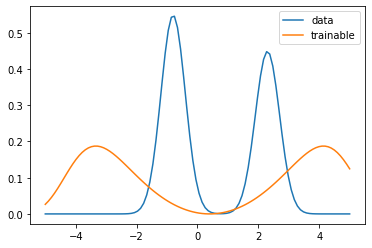

In [63]:
x = np.linspace(-5,5,100)
plt.plot(x, mix_gauss.prob(x), label='data')
plt.plot(x, trainable_dist.prob(x), label='trainable')
plt.legend()
plt.show()

In [64]:
num_epochs = 10
opt = tf.keras.optimizers.Adam()
train_losses = []
test_losses = []

for epoch in range(num_epochs):
  print('Epoch {}...'.format(epoch))
  train_loss = tf.keras.metrics.Mean()
  test_loss = tf.keras.metrics.Mean()

  for train_batch in X_train:
    with tf.GradientTape() as tape:
      tape.watch(trainable_inv_cubcic.trainable_variables)
      loss = -trainable_dist.log_prob(train_batch)
    train_loss(loss)
    grads = tape.gradient(loss, trainable_inv_cubcic.trainable_variables)
    opt.apply_gradients(zip(grads, trainable_inv_cubcic.trainable_variables))
  train_losses.append(train_loss.result().numpy())

  for test_batch in X_test:
    loss = -trainable_dist.log_prob(test_batch)
    test_loss(loss)
  test_losses.append(test_loss.result().numpy())

Epoch 0...
Epoch 1...
Epoch 2...
Epoch 3...
Epoch 4...
Epoch 5...
Epoch 6...
Epoch 7...
Epoch 8...
Epoch 9...


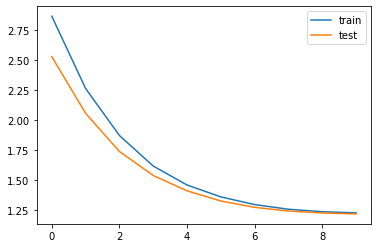

In [65]:
# plot learning curves
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.show()

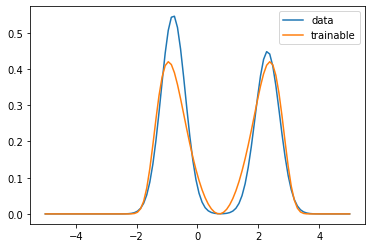

In [66]:
x = np.linspace(-5,5,100)
plt.plot(x, mix_gauss.prob(x), label='data')
plt.plot(x, trainable_dist.prob(x), label='trainable')
plt.legend()
plt.show()

In [67]:
trainable_inv_cubcic.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.56060535>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.39960486>)

## Normalizing Flows
- create compicated distributions by apply bijectors chained together to a simple, well-understood distribution (e.g. Gaussian)
- Calculating determinant is computationally complex: $O(D^3)$, so simplifications are required
- The determinant of a upper/lower triangular matrix is the product of the diagonal entries so complexity scales linearly
- Force lower triangular matrix using autoregressive flows where variables only depend on components lower than or equal to them.
  - masked autoregressive flows: mask weights so that $x_i$ only depends on $x_j$ with $j<i$
    - forward pass through bijector is slow but inverse pass is fast

### Autoregressive flows




In [68]:
# let's say data is D-dimensional and is represented by vector x
# we define an ordereing to the data features, indexed by i
# express joint distribution of all data features as a product of conditional distributions where each conditional probability of
      # x_i depends only on x_0 : x_i-1
# z ~ N(0,I)
# x[i] = z[i] * scale(z[0:i-1]) + loc(x[0:i-1]) # each x is modeled as gaussian with mean/loc functions of x_0 : x_i-1
# this is a masked autoregressive flow
# Jacobian determinant is easy to compute since the Jacobian is lower triangular so it is just a product of diagonal (linear complexity)

# use this to define autoregressive flow bijector
made = tfb.AutoregressiveNetwork(params=2, event_shape=[3], hidden_units=[16, 16], activation='sigmoid')
# made --> masked auto encoder for distribution estimation
# feed forward neural network, in this case, with 2 hidden layers with size 16
made(tf.random.normal([2,3])) # input batch of 2, with input len 3 (necessary since event_shape=3)
# output has same shape as input with extra dimension on right of size 2 because params=2
# think of this as implementing the scale/loc functions described above
# network outputs two parameters, each with length 3 --> can use first as mean and second as log of stddev
# so each feature has a mean and stddev
# network respects the autoregressive property

<tf.Tensor: shape=(2, 3, 2), dtype=float32, numpy=
array([[[ 0.        ,  0.        ],
        [-0.2949697 , -0.22095796],
        [-0.5112145 , -0.6393012 ]],

       [[ 0.        ,  0.        ],
        [-0.29510465, -0.22086605],
        [-0.5108534 , -0.63928604]]], dtype=float32)>

In [69]:
# we want to use parameters output by made network to shift and scale z[i]
maf_bijector = tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made) # this is a bijector that does that
# input z into bijector and it applies shift and log scale based on parameters of made network
# has to be performed in a loop to calculate earlier features before later features can be determined
# inverse does not require loop since we already have the entire vector x, so calculating z is easy
normal = tfd.MultivariateNormalDiag(loc=0, scale_diag=[1]*3)
maf = tfd.TransformedDistribution(normal, maf_bijector)
maf

<tfp.distributions.TransformedDistribution 'masked_autoregressive_flowMultivariateNormalDiag' batch_shape=[] event_shape=[3] dtype=float32>

In [70]:
# can also specify bijector to just shift using the following (only passing in first parameter of made) (or alternatively just scale)
maf_bijector = tfb.MaskedAutoregressiveFlow(lambda y: (made(y)[...,0], None), is_constant_jacobian=True)

In [71]:
# RealNVP
# z ~ N(0,I)
# x[0: d] = z[0: d]
# x[d: D] = z[d: D] * scale(z[0: d]) + loc(z[0: d])
shift_and_log_scale_fn = tfb.real_nvp_default_template(hidden_layers=[32, 32], activation=tf.nn.relu)
# input of this function is z[0: d] and output is scale(z[0: d]) and loc(z[0: d])

shift_and_log_scale_fn = tfb.real_nvp_default_template(hidden_layers=[32, 32], activation=tf.nn.relu, shift_only=True)
# returns tuple, but second one is None since it is shift only
# this is the NICE model - Jacobian is identity matrix so it is volume preserving

realnvp_bijector = tfb.RealNVP(num_masked=2, shift_and_log_scale_fn=shift_and_log_scale_fn)
# num_masked is little d above (can also use fraction_masked)
# forward and inverse functions do not require loop to compute 
# downside is it is not as expressive as autoregressive flow

mvn = tfd.MultivariateNormalDiag(loc=[0., 0., 0.])
realnvp = tfd.TransformedDistribution(mvn, realnvp_bijector)

In [ ]:
# because RealNVP doesn't change some of the inputs, we need to combine multiple chained bijectors with
          # permutation bijector in between which allows all features to have a chance to be in d:D range
permute = tfp.bijectors.Permute(permutation=[1, 2, 0]) # moves axis 0 to last dimension each time it is called

realnvp1 = tfb.RealNVP(fraction_masked=0.5, shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=[32,32]))
realnvp2 = tfb.RealNVP(fraction_masked=0.5, shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=[32,32]))
realnvp3 = tfb.RealNVP(fraction_masked=0.5, shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=[32,32]))

chained_bijector = tfb.Chain([realnvp3, permute, realnvp2, permute, realnvp1])

mvn = tfd.MultivariateNormalDiag(loc=[0., 0., 0.])
realnvp = tfd.TransformedDistribution(mvn, chained_bijector)

(-2.0, 2.0)

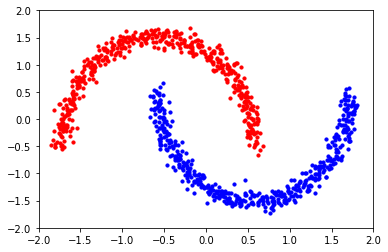

In [77]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
n_samples=1000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
X, y = noisy_moons
X_data = StandardScaler().fit_transform(X)
xlim, ylim = [-2, 2], [-2, 2]
y_label = y.astype(np.bool)
X_train, y_train = X_data[..., 0], X_data[..., 1]
plt.scatter(X_train[y_label], y_train[y_label], s=10, color='blue')
plt.scatter(X_train[~y_label], y_train[~y_label], s=10, color='red')
plt.xlim(xlim)
plt.ylim(ylim)

In [79]:
base_distribution = tfd.Independent(tfd.Normal(loc=[0, 0], scale=[1,1]), reinterpreted_batch_ndims=1)

def make_masked_autoregressive_flow(hidden_units=[16, 16], activation='relu'):
  made = tfb.AutoregressiveNetwork(
      params=2, event_shape=[2], hidden_units=hidden_units, activation=activation
  )
  return tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)

trainable_distribution = tfd.TransformedDistribution(base_distribution, make_masked_autoregressive_flow())

In [80]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow.compat.v1 import logging
logging.set_verbosity(logging.ERROR)

In [92]:
def plot_contour_prob(dist, rows=1, title=[''], scale_fig=4):
  cols = int(len(dist) / rows)
  xx = np.linspace(-5, 5, 100)
  yy = np.linspace(-5, 5, 100)
  X, Y = np.meshgrid(xx, yy)

  fig, ax = plt.subplots(rows, cols, figsize=(scale_fig * cols, scale_fig * rows))
  fig.tight_layout(pad=4.5)

  i = 0
  for r in range(rows):
    for c in range(cols):
      Z = dist[i].prob(np.dstack((X,Y)))
      if len(dist) == 1:
        axi = ax
      elif rows == 1:
        axi = ax[c]
      else:
        axi = ax[r, c]
      p = ax.contourf(X, Y, Z)
      i += 1  

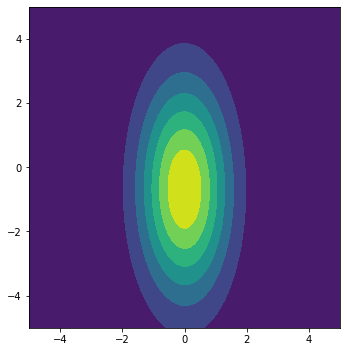

In [93]:
activation = 'sigmoid'
maf = tfd.TransformedDistribution(base_distribution, make_masked_autoregressive_flow(activation=activation))
plot_contour_prob([maf], scale_fig=6)

In [94]:
X = base_distribution.sample((1000, 2))
names = [base_distribution.name, trainable_distribution.name]
samples = [X, trainable_distribution.bijector.forward(X)]

In [95]:
def _plot(results, rows=1, legend=False):
  cols = int(len(results) / rows)
  f, arr = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
  i = 0
  for r in range(rows):
    for c in range(cols):
      res = results[i]
      X, Y = res[..., 0].numpy(), res[..., 1].numpy()
      if rows == 1:
        p = arr[c]
      else:
        p = arr[r, c]
      p.scatter(X, Y, s=10, color='red')
      p.set_xlim([-5, 5])
      p.set_ylim([-5, 5])
      p.set_title(names[i])
      i += 1

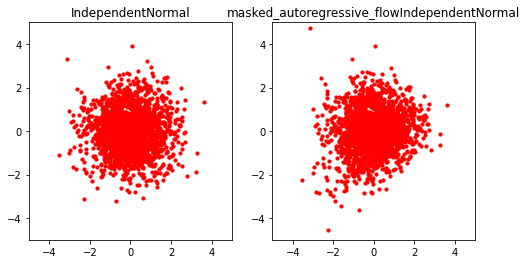

In [96]:
_plot(samples)

In [134]:
from tensorflow.keras.callbacks import LambdaCallback

def train_dist_routine(trainable_distribution, n_epochs=200, batch_size=None, n_disp=100):
  x_ = Input(shape=(2,), dtype=tf.float32)
  log_prob = trainable_distribution.log_prob(x_)
  model = Model(x_, log_prob)

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss = lambda _, log_prob: -log_prob)

  ns = X_data.shape[0]
  if batch_size is None:
    batch_size = ns

  # display loss every n_disp epoch
  epoch_callback = LambdaCallback(
      on_epoch_end = lambda epoch, logs:
      print('\n Epoch {}/{}'.format(epoch+1, n_epochs, logs),
            '\n\t ' + (': {:.4f}, '.join(logs.keys()) + ': {:.4f}').format(*logs.values()))
      if epoch % n_disp == 0 else False)
  
  history = model.fit(X_data,
                      y=np.zeros((ns, 0), dtype=np.float32),
                      batch_size=batch_size,
                      epochs=n_epochs,
                      validation_split=0.2,
                      shuffle=True,
                      verbose=False,
                      callbacks=[epoch_callback])
  return history

In [106]:
history = train_dist_routine(trainable_distribution, n_epochs=600, n_disp=50)


 Epoch 1/600 
	 loss: 2.1344, val_loss: 2.1201

 Epoch 51/600 
	 loss: 2.0969, val_loss: 2.0867

 Epoch 101/600 
	 loss: 2.0777, val_loss: 2.0618

 Epoch 151/600 
	 loss: 2.0606, val_loss: 2.0427

 Epoch 201/600 
	 loss: 2.0478, val_loss: 2.0307

 Epoch 251/600 
	 loss: 2.0377, val_loss: 2.0224

 Epoch 301/600 
	 loss: 2.0294, val_loss: 2.0170

 Epoch 351/600 
	 loss: 2.0219, val_loss: 2.0132

 Epoch 401/600 
	 loss: 2.0154, val_loss: 2.0107

 Epoch 451/600 
	 loss: 2.0098, val_loss: 2.0065

 Epoch 501/600 
	 loss: 2.0045, val_loss: 2.0022

 Epoch 551/600 
	 loss: 2.0002, val_loss: 1.9975


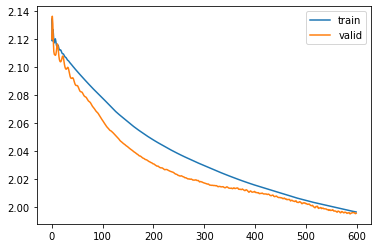

In [107]:
train_losses = history.history['loss']
valid_losses = history.history['val_loss']

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.show()

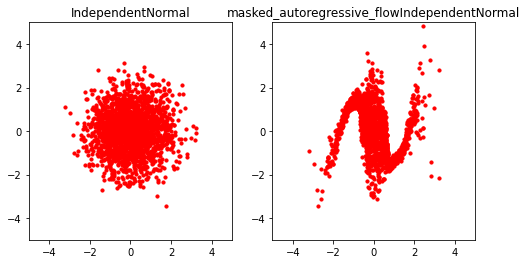

In [108]:
X = base_distribution.sample((1000, 2))
names = [base_distribution.name, trainable_distribution.name]
samples = [X, trainable_distribution.bijector.forward(X)]
_plot(samples)

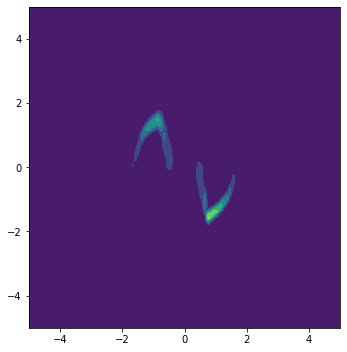

In [109]:
plot_contour_prob([trainable_distribution], scale_fig=6)

In [135]:
# chained masked autoregressive flow bijectors

num_bijectors = 6
bijectors = []

for i in range(num_bijectors):
  masked_auto_i = make_masked_autoregressive_flow(hidden_units=[256, 256], activation='relu')
  bijectors.append(masked_auto_i)
  bijectors.append(tfb.Permute(permutation=[1,0]))

flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

In [136]:
trainable_distribution = tfd.TransformedDistribution(base_distribution, flow_bijector)

In [125]:
def make_samples():
  x = base_distribution.sample((1000, 2))
  samples = [x]
  names = [base_distribution.name]
  for bijector in reversed(trainable_distribution.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)
  return names, samples

names, samples = make_samples()

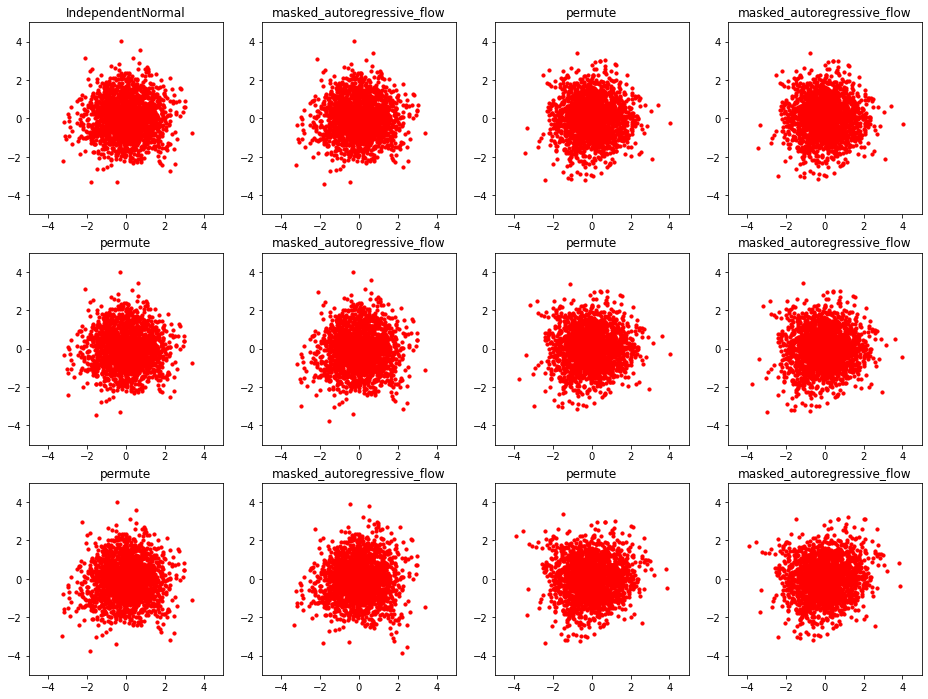

In [126]:
_plot(samples, rows=3)

In [137]:
history = train_dist_routine(trainable_distribution, n_epochs=600, n_disp=50)


 Epoch 1/600 
	 loss: 2.9017, val_loss: 2.7577

 Epoch 51/600 
	 loss: 2.1249, val_loss: 2.1591

 Epoch 101/600 
	 loss: 2.0991, val_loss: 2.1085

 Epoch 151/600 
	 loss: 2.0852, val_loss: 2.0715

 Epoch 201/600 
	 loss: 3.3094, val_loss: 3.2642

 Epoch 251/600 
	 loss: 2.2898, val_loss: 2.2906

 Epoch 301/600 
	 loss: 1.9766, val_loss: 2.1654

 Epoch 351/600 
	 loss: 1.8411, val_loss: 2.0193

 Epoch 401/600 
	 loss: 1.6904, val_loss: 2.0140

 Epoch 451/600 
	 loss: 1.5796, val_loss: 1.9824

 Epoch 501/600 
	 loss: 1.5000, val_loss: 2.5046

 Epoch 551/600 
	 loss: 1.4864, val_loss: 6.3518


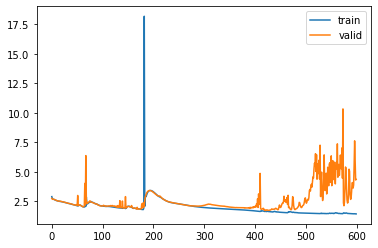

In [138]:
train_losses = history.history['loss']
valid_losses = history.history['val_loss']

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.show()

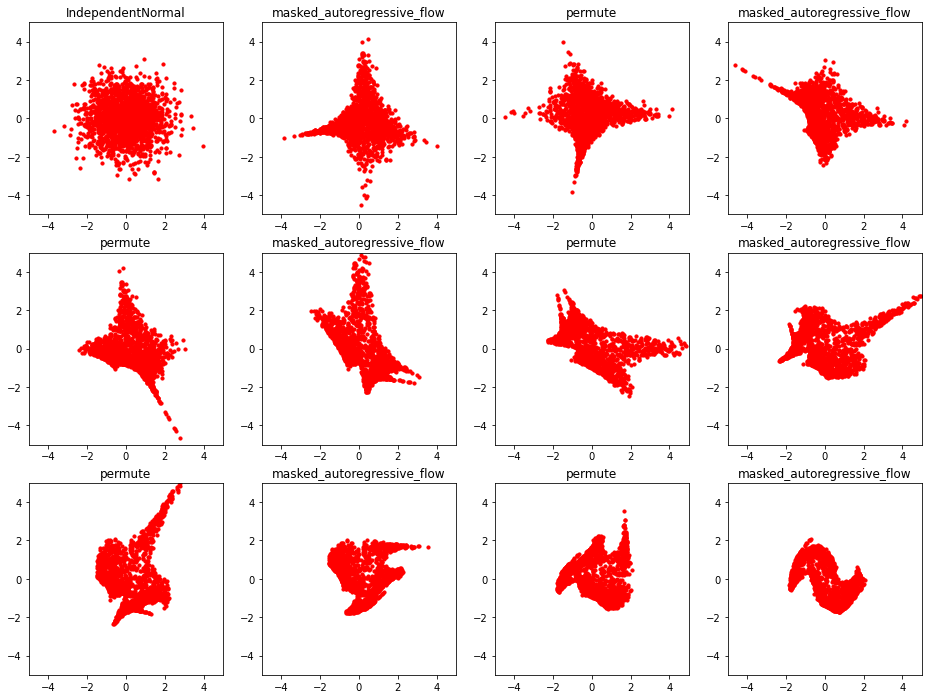

In [139]:
names, samples = make_samples()
_plot(samples, rows=3)

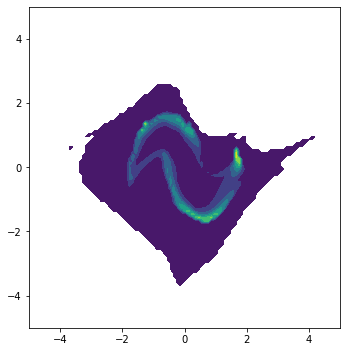

In [140]:
plot_contour_prob([trainable_distribution], scale_fig=6)